<a href="https://colab.research.google.com/github/dominiksakic/zero_to_hero/blob/main/experiments_grad_activations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -- Boilerpalte -- #
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2025-06-26 11:33:51--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.01s   

2025-06-26 11:33:52 (14.7 MB/s) - ‘names.txt’ saved [228145/228145]



In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [6]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i : s for s, i in stoi.items()}
vocab_size = len(itos)

block_size = 3

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# Implementing the Code via Torch-like API
class Linear:
  def __init__(self,fan_in, fan_out, bias=True):
    self.weight = torch.randn(fan_in, fan_out) / fan_in ** 0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out =  x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class Batch1DNorm:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.training = True
    self.momentum = momentum
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    if self.training:
      xmean = x.mean(0, keepdim=True)
      xvar = x.var(0, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.running_mean * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.running_mean * xvar

    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

In [8]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)


n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), Batch1DNorm(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), Batch1DNorm(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), Batch1DNorm(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), Batch1DNorm(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), Batch1DNorm(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), Batch1DNorm(vocab_size)
]


with torch.no_grad():
  layers[-1].gamma *= 0.1
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

47024


In [9]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)

  # backward pass
  for layer in layers:
    layer.out.retain_grad()
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break

      0/ 200000: 3.3108


layer 2 (      Tanh): mean +0.00, std 0.63, saturated: 3.34%
layer 5 (      Tanh): mean -0.00, std 0.63, saturated: 3.28%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.75%
layer 11 (      Tanh): mean -0.00, std 0.65, saturated: 2.47%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 2.44%


Text(0.5, 1.0, 'activation distribution')

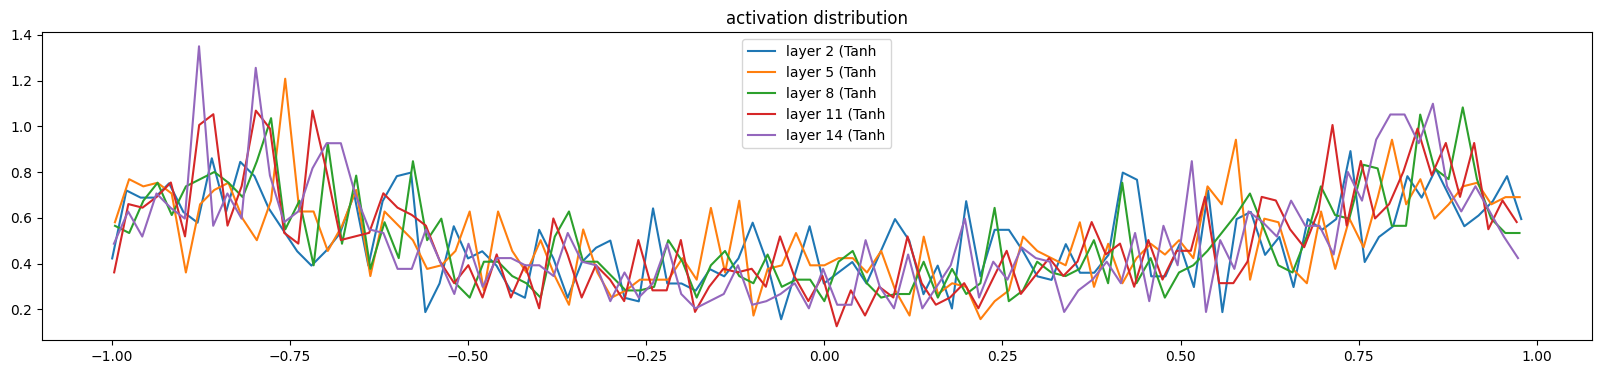

In [10]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 3.550166e-03
layer 5 (      Tanh): mean -0.000000, std 2.915951e-03
layer 8 (      Tanh): mean +0.000000, std 2.776820e-03
layer 11 (      Tanh): mean -0.000000, std 2.560242e-03
layer 14 (      Tanh): mean -0.000000, std 2.456260e-03


Text(0.5, 1.0, 'gradient distribution')

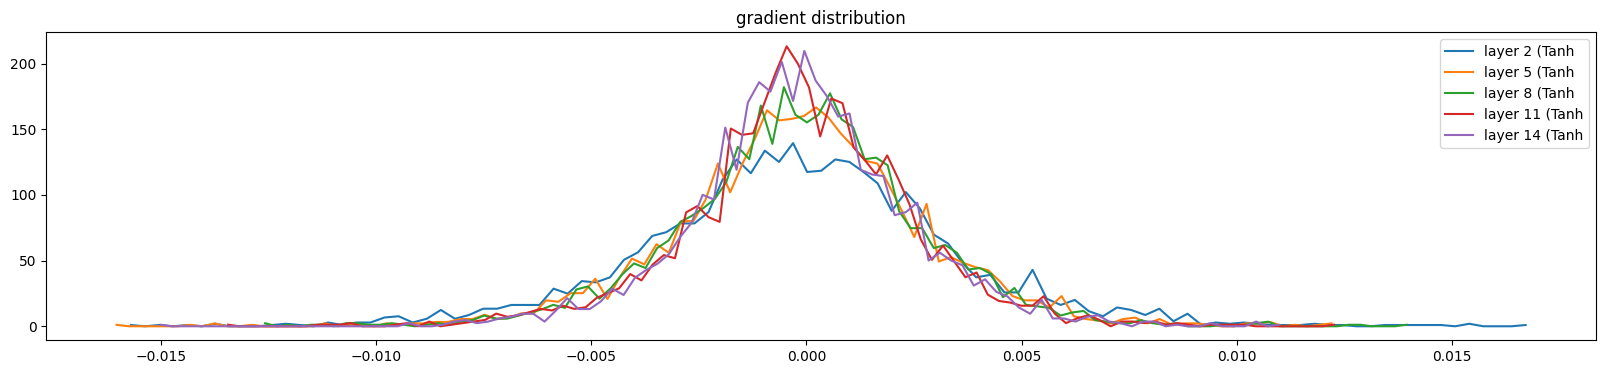

In [11]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.035725e-02 | grad:data ratio 1.034634e-02
weight  (30, 100) | mean -0.000106 | std 7.965761e-03 | grad:data ratio 2.523439e-02
weight (100, 100) | mean +0.000026 | std 6.247825e-03 | grad:data ratio 3.666233e-02
weight (100, 100) | mean -0.000024 | std 5.585846e-03 | grad:data ratio 3.323760e-02
weight (100, 100) | mean +0.000041 | std 5.095579e-03 | grad:data ratio 3.036583e-02
weight (100, 100) | mean -0.000027 | std 4.729711e-03 | grad:data ratio 2.832388e-02
weight  (100, 27) | mean +0.000057 | std 8.693961e-03 | grad:data ratio 5.154667e-02


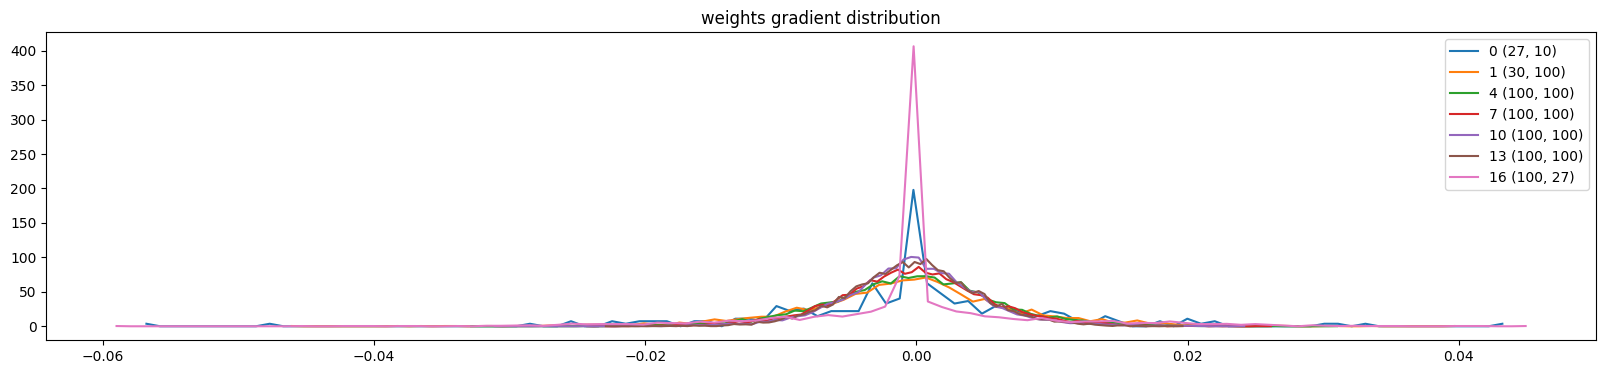

In [12]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');


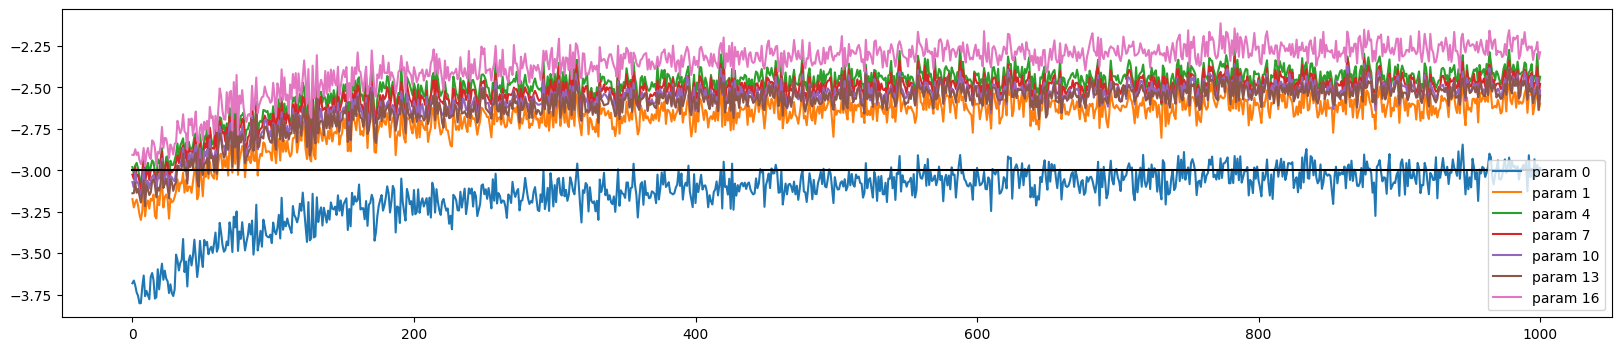

In [13]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends);

In [43]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)


n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), Batch1DNorm(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), Batch1DNorm(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), Batch1DNorm(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), Batch1DNorm(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), Batch1DNorm(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), Batch1DNorm(vocab_size)
]


with torch.no_grad():
  layers[-1].gamma *= 0.1
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)

  # backward pass
  for layer in layers:
    layer.out.retain_grad()
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.01 if i < 150000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break

47024
      0/ 200000: 3.3319


- Low lr

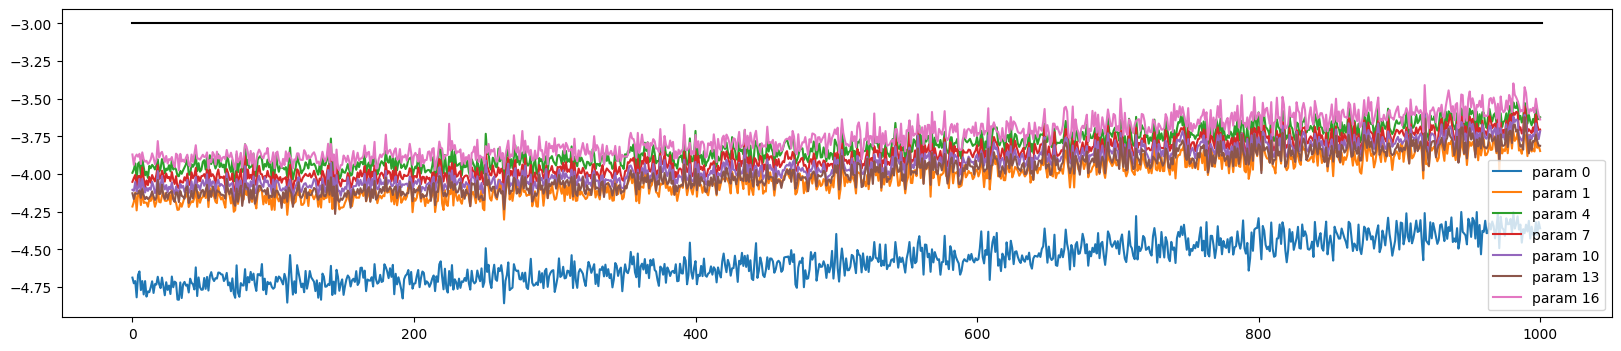

In [44]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends);

weight   (27, 10) | mean +0.000000 | std 4.360852e-03 | grad:data ratio 4.357696e-03
weight  (30, 100) | mean -0.000008 | std 4.243153e-03 | grad:data ratio 1.419947e-02
weight (100, 100) | mean -0.000003 | std 3.919916e-03 | grad:data ratio 2.380490e-02
weight (100, 100) | mean -0.000022 | std 3.279339e-03 | grad:data ratio 1.969816e-02
weight (100, 100) | mean +0.000052 | std 3.183531e-03 | grad:data ratio 1.917359e-02
weight (100, 100) | mean -0.000038 | std 2.552690e-03 | grad:data ratio 1.538382e-02
weight  (100, 27) | mean +0.000063 | std 3.776621e-03 | grad:data ratio 2.299187e-02


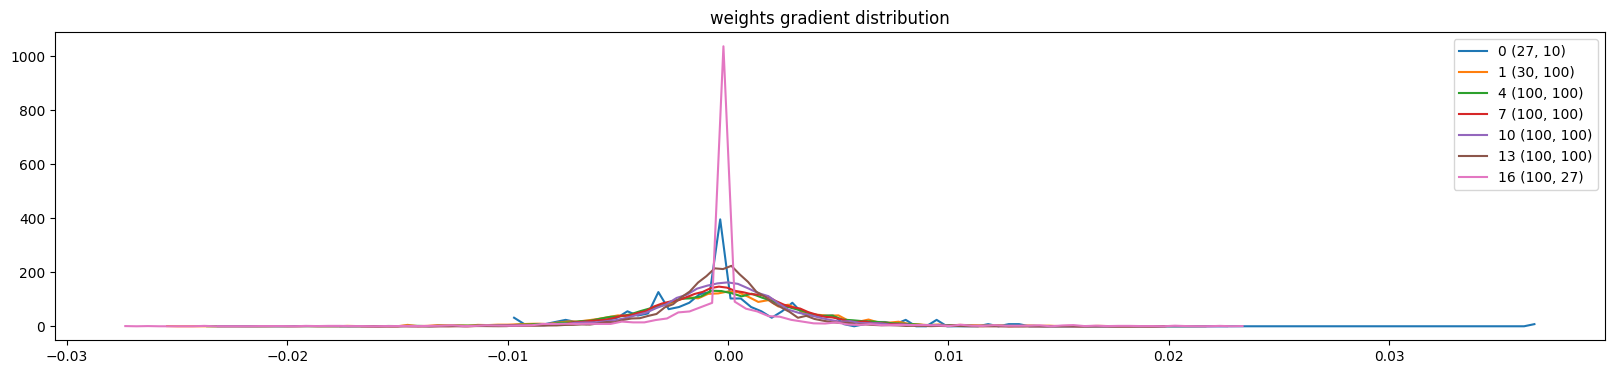

In [45]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');


In [40]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)


n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), Batch1DNorm(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), Batch1DNorm(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), Batch1DNorm(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), Batch1DNorm(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), Batch1DNorm(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), Batch1DNorm(vocab_size)
]


with torch.no_grad():
  layers[-1].gamma *= 0.1
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)

  # backward pass
  for layer in layers:
    layer.out.retain_grad()
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 10 if i < 150000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break

47024
      0/ 200000: 3.2846


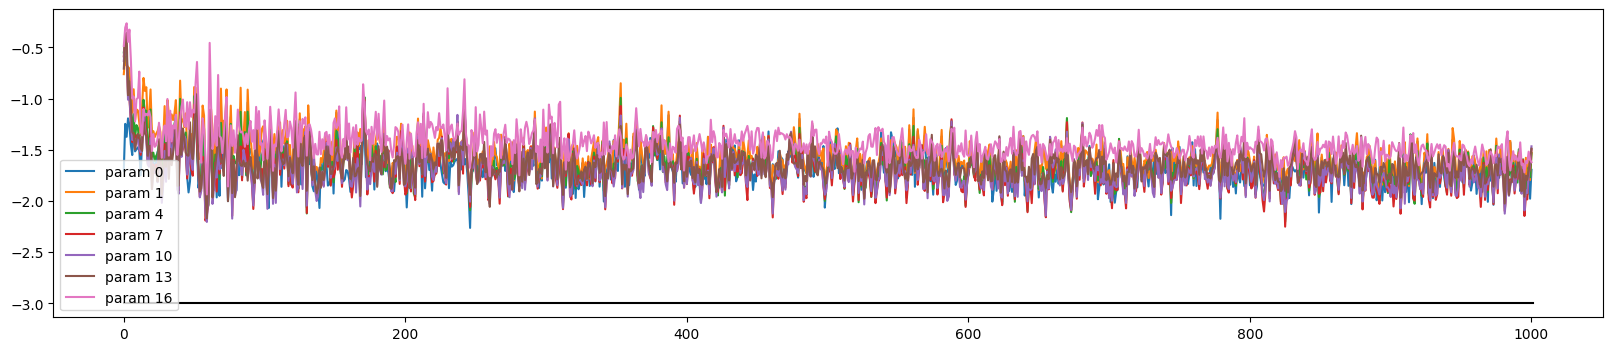

In [41]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends);

weight   (27, 10) | mean -0.000000 | std 2.864203e-03 | grad:data ratio 2.013711e-03
weight  (30, 100) | mean +0.000004 | std 1.146098e-03 | grad:data ratio 2.958772e-03
weight (100, 100) | mean -0.000001 | std 4.944733e-04 | grad:data ratio 2.924605e-03
weight (100, 100) | mean +0.000000 | std 5.057648e-04 | grad:data ratio 3.193113e-03
weight (100, 100) | mean +0.000000 | std 5.487463e-04 | grad:data ratio 3.416980e-03
weight (100, 100) | mean -0.000006 | std 5.670089e-04 | grad:data ratio 3.241165e-03
weight  (100, 27) | mean -0.000021 | std 1.161293e-03 | grad:data ratio 2.391350e-03


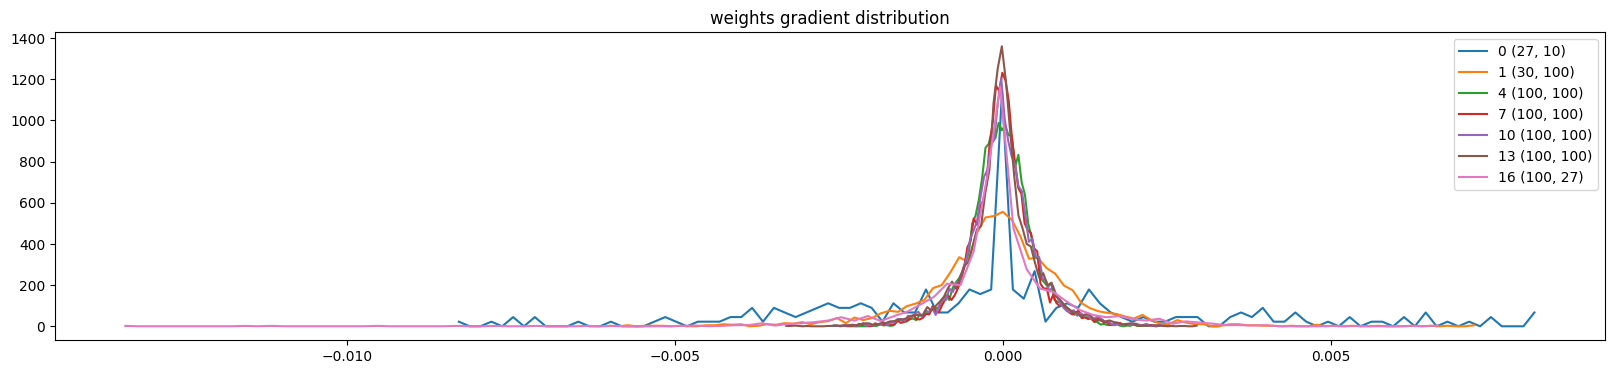

In [42]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');


- Try just linear layers

In [74]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)


n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden),
  Linear(           n_hidden, n_hidden),
  Linear(           n_hidden, n_hidden),
  Linear(           n_hidden, n_hidden),
  Linear(           n_hidden, n_hidden),
  Linear(           n_hidden, vocab_size),
]


with torch.no_grad():
  layers[-1].weight *= 0.1
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)

  # backward pass
  for layer in layers:
    layer.out.retain_grad()
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 10 if i < 150000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  break

46497
      0/ 200000: 3.9978


layer 0 (    Linear): mean -0.05, std 1.54, saturated: 51.44%
layer 1 (    Linear): mean +0.04, std 2.58, saturated: 69.62%
layer 2 (    Linear): mean -0.14, std 4.13, saturated: 80.97%
layer 3 (    Linear): mean +0.16, std 6.69, saturated: 86.91%
layer 4 (    Linear): mean -0.38, std 11.01, saturated: 92.94%


Text(0.5, 1.0, 'activation distribution')

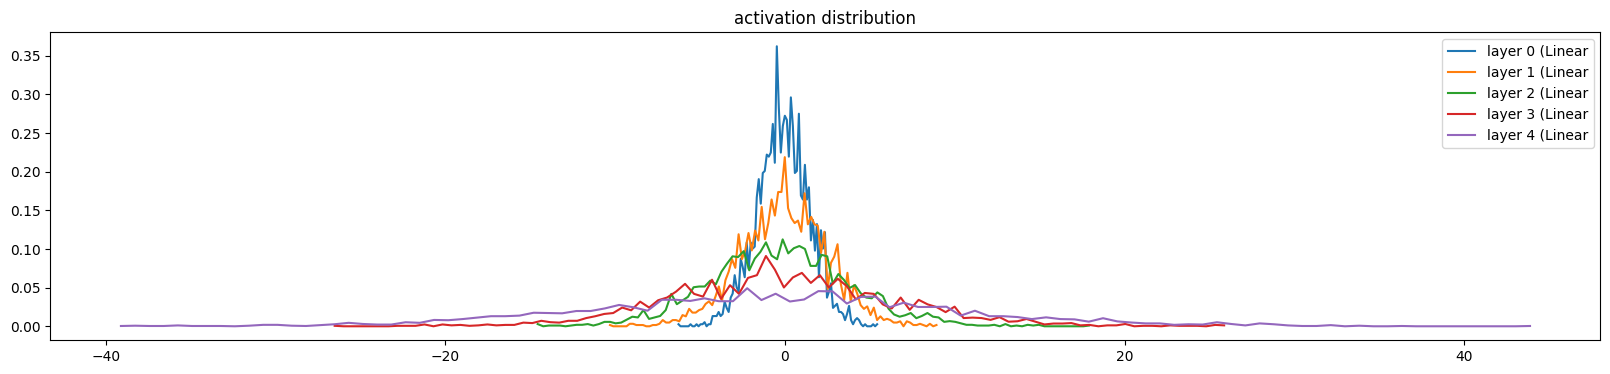

In [75]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Linear):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 0 (    Linear): mean +0.000033, std 2.511139e-03
layer 1 (    Linear): mean -0.000025, std 1.497989e-03
layer 2 (    Linear): mean +0.000002, std 9.127632e-04
layer 3 (    Linear): mean -0.000001, std 5.366174e-04
layer 4 (    Linear): mean -0.000006, std 3.209144e-04


Text(0.5, 1.0, 'gradient distribution')

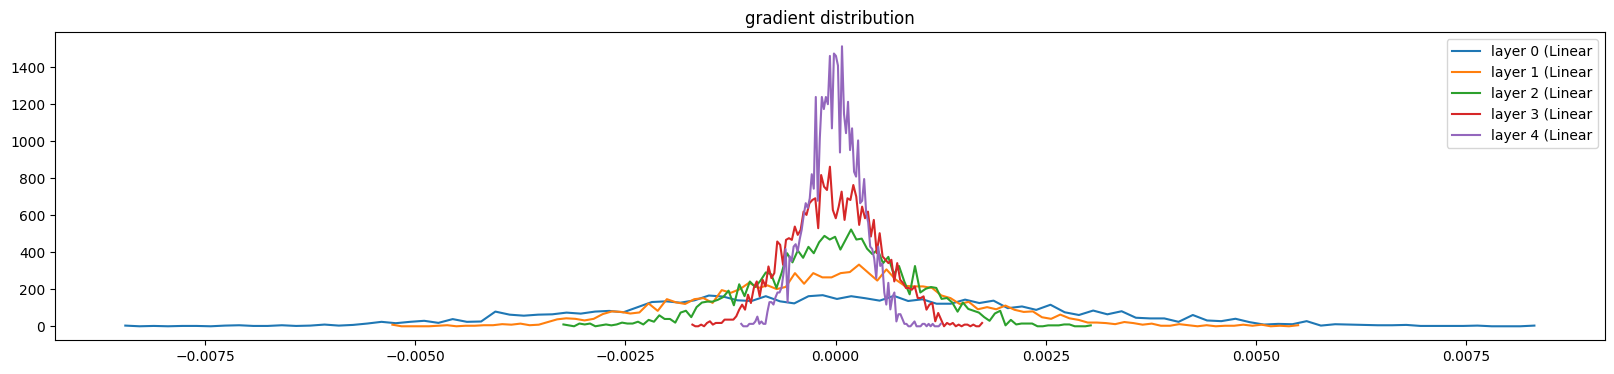

In [76]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Linear):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.002409 | std 1.888876e-02 | grad:data ratio 1.946837e-02
weight  (30, 100) | mean -0.000091 | std 1.720683e-02 | grad:data ratio 5.195927e-02
weight (100, 100) | mean +0.000060 | std 1.640897e-02 | grad:data ratio 7.187428e-02
weight (100, 100) | mean +0.000148 | std 1.707918e-02 | grad:data ratio 7.319422e-02
weight (100, 100) | mean +0.000035 | std 1.493966e-02 | grad:data ratio 6.863739e-02
weight (100, 100) | mean -0.000122 | std 1.387780e-02 | grad:data ratio 6.577630e-02
weight  (100, 27) | mean +0.000000 | std 4.341337e-01 | grad:data ratio 1.000248e-01


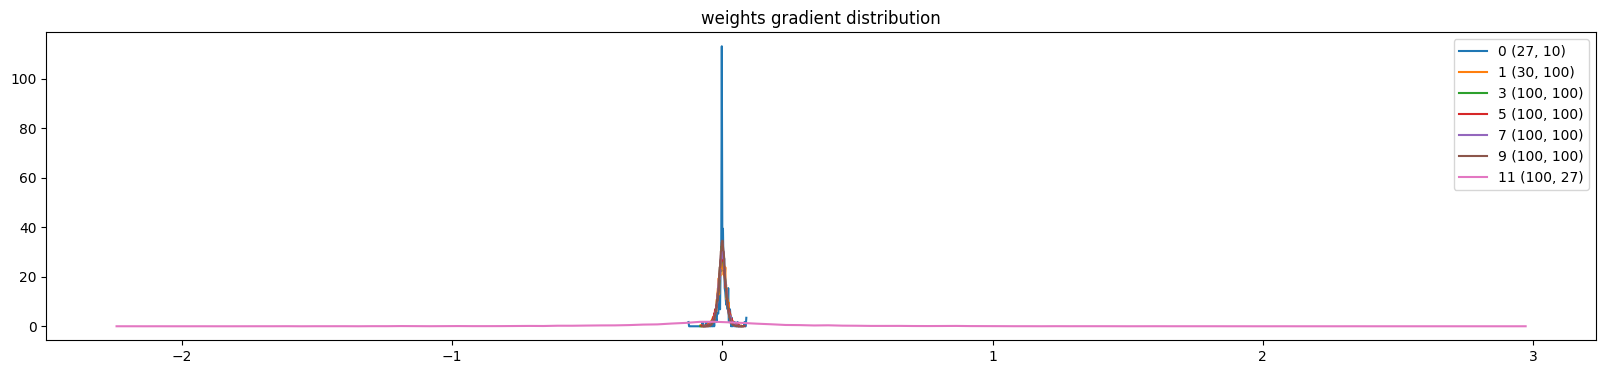

In [77]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');


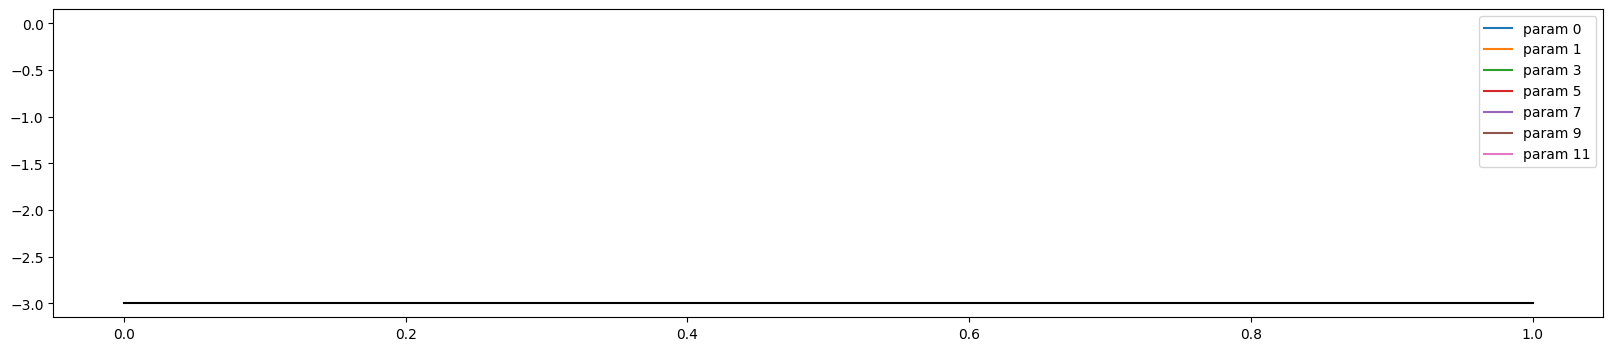

In [78]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends);